In [1]:
# Our developed libraries
using CombinatorialSpaces
using CombinatorialSpaces.ExteriorCalculus


using Catlab.Present
using Catlab.Graphics
using Catlab.CategoricalAlgebra
using Catlab, Catlab.CategoricalAlgebra, Catlab.Graphics, Catlab.Programs
using CombinatorialSpaces.ExteriorCalculus
using AlgebraicPetri
using LinearAlgebra

# Julia community libraries
using MeshIO
using CairoMakie
using DifferentialEquations
using Distributions
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

using Revise
using Decapods.Simulations
using Decapods.Examples
using Decapods.Diagrams
using Decapods.Schedules
using Decapods.Debug
using Decapods.OpenDiagrams
using Decapods.PetriNets

[ Info: Precompiling Decapods [679ab3ea-c928-4fe6-8d59-fd451142d391]


In [2]:
module EnzymeReactions

using AlgebraicPetri
using Catlab.Programs
using Catlab.Graphics
using Catlab.WiringDiagrams
using Catlab.CategoricalAlgebra
using Distributions

using DifferentialEquations
using Plots
using Plots.PlotMeasures
export ob, ode,
       inactivate, bindunbind, degrade,
       enzX, enzXY, enzXsubY,
       enz, enz_enz, enz_sub,
       enzyme_uwd, enzyme_generators

sep_sym = "↦"
ob(type, x) = codom(Open([first(x)], LabelledReactionNet{type,Number}(x), [first(x)])).ob;
ob(x) = codom(Open([x], LabelledPetriNet(x), [x])).ob;


function inactivate(in,on::T) where T
  inact = Symbol(first(in), :_inact)
  Open(LabelledReactionNet{T,Number}(unique((in, inact=>0)), ((Symbol(:inact_,first(in)),on),first(in)=>inact)))
end;

function bindunbind(in1, in2, on::T, off::T) where T
  out = Symbol(first(in1), sep_sym,first(in2))
  Open(LabelledReactionNet{T,Number}(unique((in1, in2,out=>0)), ((Symbol(:bind_,first(in1), sep_sym,first(in2)),on),(first(in1),first(in2))=>out),
                                                                ((Symbol(:unbind_,out),off),out=>(first(in1),first(in2)))))
end;

function degrade(prod1,prod2,on::T) where T
  in = Symbol(first(prod1), sep_sym,first(prod2))
  prod2str = String(first(prod2))
  degprod2 = Symbol(endswith(prod2str, "inact") ? first(prod2str) : prod2str, :_deg)
  Open(LabelledReactionNet{T,Number}(unique((in=>0, prod1,degprod2=>0)), ((Symbol(:deg_,in),on),in=>(first(prod1),degprod2))));
end;

function inactivate(in)
  inact = Symbol(in, :_inact)
  Open(LabelledPetriNet(unique((in, inact)), (Symbol(:inact_,in),in=>inact)))
end;

function bindunbind(in1, in2)
  out = Symbol(in1, sep_sym,in2)
  Open(LabelledPetriNet(unique((in1, in2,out)), (Symbol(:bind_,in1, sep_sym,in2),(in1,in2)=>out),
                                                (Symbol(:unbind_,out),out=>(in1,in2))))
end;

function degrade(prod1,prod2)
  in = Symbol(prod1, sep_sym,prod2)
  prod2str = String(prod2)
  degprod2 = Symbol(endswith(prod2str, "inact") ? first(prod2str) : prod2str, :_deg)
  Open(LabelledPetriNet(unique((in, prod1,degprod2)), (Symbol(:deg_,in),in=>(prod1,degprod2))));
end;

# ## Cathepsin *X* reacting with itself

enzX = @relation (X, Xinact, Xdeg) where (X, Xinact, Xdeg, XX, XXinact) begin
  inactX(X, Xinact)
  bindXX(X, XX)
  degXX(XX, X, Xdeg)
  bindXXinact(X, Xinact, XXinact)
  degXXinact(XXinact, X, Xdeg)
end

# ## Cathepsin *X* reacting with Substrate *Y*

enzXsubY = @relation (X, Xinact, Xdeg, Y, Ydeg) where (X, Xinact, Xdeg, Y, XY, Ydeg) begin
  bindXY(X, Y, XY)
  degXY(XY, X, Ydeg)
end

# ## Cathepsin *X* reacting with Cathepsin *Y*

enzXY = @relation (X, Xinact, Xdeg, Y, Yinact, Ydeg) where (X, Xinact, Xdeg, Y, Yinact, Ydeg, XY, XYinact) begin
  bindXY(X, Y, XY)
  degXY(XY, X, Ydeg)
  bindXYinact(X, Yinact, XYinact)
  degXYinact(XYinact, X, Ydeg)
end

function enz(rxns, cat)
  catsym = first(cat)
  obtype = valtype(rates(apex(first(last(first(rxns))))))
  out = oapply(enzX, Dict([:inactX, :bindXX, :degXX, :bindXXinact, :degXXinact] .=> rxns[catsym]), Dict(
    :X=>ob(obtype, cat),
    :Xinact=>ob(obtype, Symbol(catsym,:_inact)=>0),
    :Xdeg=>ob(obtype, Symbol(catsym,:_deg)=>0),
    :XX=>ob(obtype, Symbol(catsym, sep_sym,catsym)=>0),
    :XXinact=>ob(obtype, Symbol(catsym, sep_sym,catsym,:_inact)=>0)))
  bundle_legs(out, [[1,2,3]])
end

function enz_sub(rxns, cat1, sub)
  catsym = first(cat1)
  subsym = first(sub)
  catsub = Symbol(catsym, sep_sym, subsym)
  obtype = valtype(rates(apex(first(last(first(rxns))))))
  out = oapply(enzXsubY, Dict([:bindXY, :degXY] .=> rxns[catsub]), Dict(
    :X=>ob(obtype, cat1),
    :Xinact=>ob(obtype, Symbol(catsym,:_inact)=>0),
    :Xdeg=>ob(obtype, Symbol(catsym,:_deg)=>0),
    :Y=>ob(obtype, sub),
    :XY=>ob(obtype, Symbol(catsym,sep_sym,subsym)=>0),
    :Ydeg=>ob(obtype, Symbol(subsym,:_deg)=>0)))
  bundle_legs(out, [[1,2,3], [4,5]])
end

function enz_enz(rxns, cat1, cat2)
  cat1sym = first(cat1)
  cat2sym = first(cat2)
  catcat = Symbol(cat1sym, sep_sym, cat2sym)
  obtype = valtype(rates(apex(first(last(first(rxns))))))
  out = oapply(enzXY, Dict([:bindXY, :degXY, :bindXYinact, :degXYinact] .=> rxns[catcat]), Dict(
    :X=>ob(obtype, cat1),
    :Xinact=>ob(obtype, Symbol(cat1sym,:_inact)=>0),
    :Xdeg=>ob(obtype, Symbol(cat1sym,:_deg)=>0),
    :Y=>ob(obtype, cat2),
    :Yinact=>ob(obtype, Symbol(cat2sym,:_inact)=>0),
    :Ydeg=>ob(obtype, Symbol(cat2sym,:_deg)=>0),
    :XY=>ob(obtype, catcat=>0),
    :XYinact=>ob(obtype, Symbol(catcat,:_inact)=>0)))
  bundle_legs(out, [[1,2,3], [4,5,6]])
end

function enz(cat::Symbol)
  catsym = cat
  out = oapply(enzX, Dict(:inactX=>inactivate(cat), :bindXX=>bindunbind(cat, cat), :degXX=>degrade(cat, cat),
                          :bindXXinact=>bindunbind(cat, Symbol(cat,:_inact)),
                          :degXXinact=>degrade(cat, Symbol(cat, :_inact))), Dict(
    :X=>ob(cat),
    :Xinact=>ob(Symbol(catsym,:_inact)),
    :Xdeg=>ob(Symbol(catsym,:_deg)),
    :XX=>ob(Symbol(catsym, sep_sym,catsym)),
    :XXinact=>ob(Symbol(catsym, sep_sym,catsym,:_inact))))
  bundle_legs(out, [[1,2,3]])
end

function enz_sub(cat1::Symbol, sub::Symbol)
  catsym = cat1
  subsym = sub
  catsub = Symbol(catsym, sep_sym, subsym)
  out = oapply(enzXsubY, Dict(:bindXY=>bindunbind(cat1, sub), :degXY=>degrade(cat1, sub)), Dict(
    :X=>ob(cat1),
    :Xinact=>ob(Symbol(catsym,:_inact)),
    :Xdeg=>ob(Symbol(catsym,:_deg)),
    :Y=>ob(sub),
    :XY=>ob(Symbol(catsym, sep_sym,subsym)),
    :Ydeg=>ob(Symbol(subsym,:_deg))))
  bundle_legs(out, [[1,2,3], [4,5]])
end

function enz_enz(cat1::Symbol, cat2::Symbol)
  cat1sym = cat1
  cat2sym = cat2
  catcat = Symbol(cat1sym, sep_sym, cat2sym)
  out = oapply(enzXY, Dict(:bindXY=>bindunbind(cat1, cat2), :degXY=>degrade(cat1, cat2), :bindXYinact=>bindunbind(cat1, Symbol(cat2, :_inact)), :degXYinact=>degrade(cat1, Symbol(cat2, :_inact))), Dict(
    :X=>ob(cat1),
    :Xinact=>ob(Symbol(cat1sym,:_inact)),
    :Xdeg=>ob(Symbol(cat1sym,:_deg)),
    :Y=>ob(cat2),
    :Yinact=>ob(Symbol(cat2sym,:_inact)),
    :Ydeg=>ob(Symbol(cat2sym,:_deg)),
    :XY=>ob(catcat),
    :XYinact=>ob(Symbol(catcat,:_inact))))
  bundle_legs(out, [[1,2,3], [4,5,6]])
end

function enzyme_uwd(enzymes::Array{Symbol}, substrates::Array{Symbol})
  rel = RelationDiagram(0)

  chemicals = vcat(substrates, enzymes)

  subs = add_junctions!(rel, length(substrates), variable=substrates)
  enzs = add_junctions!(rel, length(enzymes), variable=enzymes)
  nsubs = length(subs)
  nenzs = length(enzs)

  catx = add_parts!(rel, :Box, nenzs, name=[Symbol("cat$i") for i in enzymes])
  add_parts!(rel, :Port, nenzs, junction=enzs, box=catx)

  for x in 1:nenzs
    for y in 1:nenzs
      if y != x
        catxy = add_part!(rel, :Box, name=Symbol("cat$(enzymes[x])cat$(enzymes[y])"))
        add_parts!(rel, :Port, 2, junction=[enzs[x], enzs[y]], box=catxy)
      end
    end
  end

  for x in 1:nenzs
    for y in 1:nsubs
      catxy = add_part!(rel, :Box, name=Symbol("cat$(enzymes[x])sub$(substrates[y])"))
      add_parts!(rel, :Port, 2, junction=[enzs[x], subs[y]], box=catxy)
    end
  end
  add_parts!(rel, :OuterPort, length(chemicals), outer_junction = vcat(subs, enzs))
  rel
end

function enzyme_generators(enzymes::Array{Symbol}, substrates::Array{Symbol})
  gens = Dict{Symbol, StructuredMulticospan}()
  for e1 in enzymes
    for e2 in enzymes
      if e1 == e2
        gens[Symbol(:cat, e1)] = enz(e1)
      else
        gens[Symbol(:cat, e1, :cat, e2)] = enz_enz(e1, e2)
      end
    end
    for s in substrates
      gens[Symbol(:cat, e1, :sub, s)] = enz_sub(e1, s)
    end
  end
  Dict{Symbol, typeof(first(gens)[2])}(gens)
end
end
using .EnzymeReactions

In [3]:
 K = :K=>33000;
  S = :S=>33000;
  L = :L=>33000;
  Kinact = :K_inact=>0;
  Sinact = :S_inact=>0;
  Linact = :L_inact=>0;
  E = :E=>700000;
  G = :G=>714000;
  Spike = :Spike=>66000;

  cats = [:K, :S, :L]
  subs = [:E, :G, :Spike]

  # Parameter Rates (units of pM and min)
  rxns = Dict(
    "K" => [inactivate(K, 7.494e-10)
           bindunbind(K, K, 7.814e-4, 3.867e-3)
           degrade(K, K, 2.265e-1)
           bindunbind(K, Kinact, 7.814e-4, 3.867e-3)
           degrade(K, Kinact, 2.265e-1)],
    "S" => [inactivate(S, 1.906e-2)
           bindunbind(S, S, 3.534e-7, 1.688e2)
           degrade(S, S, 1.433e1)
           bindunbind(S, Sinact, 3.534e-7, 1.688e2)
           degrade(S, Sinact, 1.433e1)],
    "L" => [inactivate(L, 7.810e-3)
           bindunbind(L, L, 1.000e-11, 7.440e3)
           degrade(L, L, 2.670e2)
           bindunbind(L, Linact, 1.000e-11, 7.440e3)
           degrade(L, Linact, 2.670e2)],
    "K↦E" => [bindunbind(K, E, 9.668e-6,1.000e-2)
            degrade(K, E, 1.728e0)],
    "K↦G" => [bindunbind(K, G, 2.764e-6, 8.780e-1)
            degrade(K, G, 1.502e0)],
    "S↦E" => [bindunbind(S, E, 4.197e-7, 1.06e-3)
            degrade(S, E, 1.384e4)],
    "S↦G" => [bindunbind(S, G, 5.152e-8, 3.894e-3)
            degrade(S, G, 8.755e-1)],
    "L↦E" => [bindunbind(L, E, 1.977e-8, 1.000e-2)
            degrade(L, E, 1.066e2)],
    "L↦G" => [bindunbind(L, G, 3.394e-8, 2.365e1)
            degrade(L, G, 4.352e0)],
    "K↦S" => [bindunbind(K, S, 8.822e-4, 4.114e5)
            degrade(K, S, 9.000e-10)
            bindunbind(K, Sinact, 8.822e-4, 4.114e5)
            degrade(K, Sinact, 9.000e-10)],
    "K↦L" => [bindunbind(K, L, 1.756e-4, 3.729e4)
            degrade(K, L, 6.505e6)
            bindunbind(K, Linact, 1.756e-4, 3.729e4)
            degrade(K, Linact, 6.505e6)],
    "S↦K" => [bindunbind(S, K, 3.679e-4, 1.562e3)
            degrade(S, K, 4.410e2)
            bindunbind(S, Kinact, 3.679e-4, 1.562e3)
            degrade(S, Kinact, 4.410e2)],
    "S↦L" => [bindunbind(S, L, 1.000e-3, 5.000e2)
            degrade(S, L, 1.000e-7)
            bindunbind(S, Linact, 1.000e-3, 5.000e2)
            degrade(S, Linact, 1.000e-7)],
    "L↦K" => [bindunbind(L, K, 1.000e-3, 4.118e3)
            degrade(L, K, 3.234e1)
            bindunbind(L, Kinact, 1.000e-3, 4.118e3)
            degrade(L, Kinact, 3.234e1)],
    "L↦S" => [bindunbind(L, S, 1.056e-12, 5.000e2)
            degrade(L, S, 5.000e-1)
            bindunbind(L, Sinact, 1.056e-12, 5.000e2)
            degrade(L, Sinact, 5.000e-1)]
  );
  rxns = Dict(Symbol(k)=>v for (k,v) in rxns)
  # define labels to reaction network mappings
  functor(x) = oapply(x, Dict(
    :catK=>enz(rxns, K),
    :catS=>enz(rxns, S),
    :catL=>enz(rxns, L),
    :catKcatS=>enz_enz(rxns, K,S),
    :catKcatL=>enz_enz(rxns, K,L),
    :catScatK=>enz_enz(rxns, S,K),
    :catScatL=>enz_enz(rxns, S,L),
    :catLcatK=>enz_enz(rxns, L,K),
    :catLcatS=>enz_enz(rxns, L,S),
    :catKsubE=>enz_sub(rxns, K,E),
    :catSsubE=>enz_sub(rxns, S,E),
    :catLsubE=>enz_sub(rxns, L,E),
    :catKsubG=>enz_sub(rxns, K,G),
    :catSsubG=>enz_sub(rxns, S,G),
    :catLsubG=>enz_sub(rxns, L,G)));
  lfunctor(x) = oapply(x, enzyme_generators([:K,:S,:L],[:G,:E,:Spike]))
  def_model = apex(functor(enzyme_uwd([:K,:S,:L],[:G,:E])))
  def_rates = rates(def_model)
  def_concs = Dict(c=>concentrations(def_model)[c] for c in snames(def_model))
  def_concs[:Spike] = Spike[2]
  def_concs[:Spike_deg] = 0
  def_concs[Symbol("K↦Spike")] = 0
  def_concs[Symbol("S↦Spike")] = 0
  def_concs[Symbol("L↦Spike")] = 0
  nothing

In [4]:
#uwd = enzyme_uwd([:K, :S], [:G, :Spike])
uwd = enzyme_uwd([:K], [:G])
model = lfunctor(uwd) |> apex;

In [5]:
using JSON
val = Dict()
val = open("../../../../../aske/alg_petri_models/pred_param_KSSpike_updated.json", "r") do f
    JSON.parse(f)
end;

In [6]:
lrn = LabelledReactionNet{Float64, Float64}()
copy_parts!(lrn, model)
lrn[:rate] .= [val[String(t)] for t in tnames(model)]
lrn[:concentration] .= fill(0.0, ns(model));

incident(graph, :Ṙ, :vname) = 0


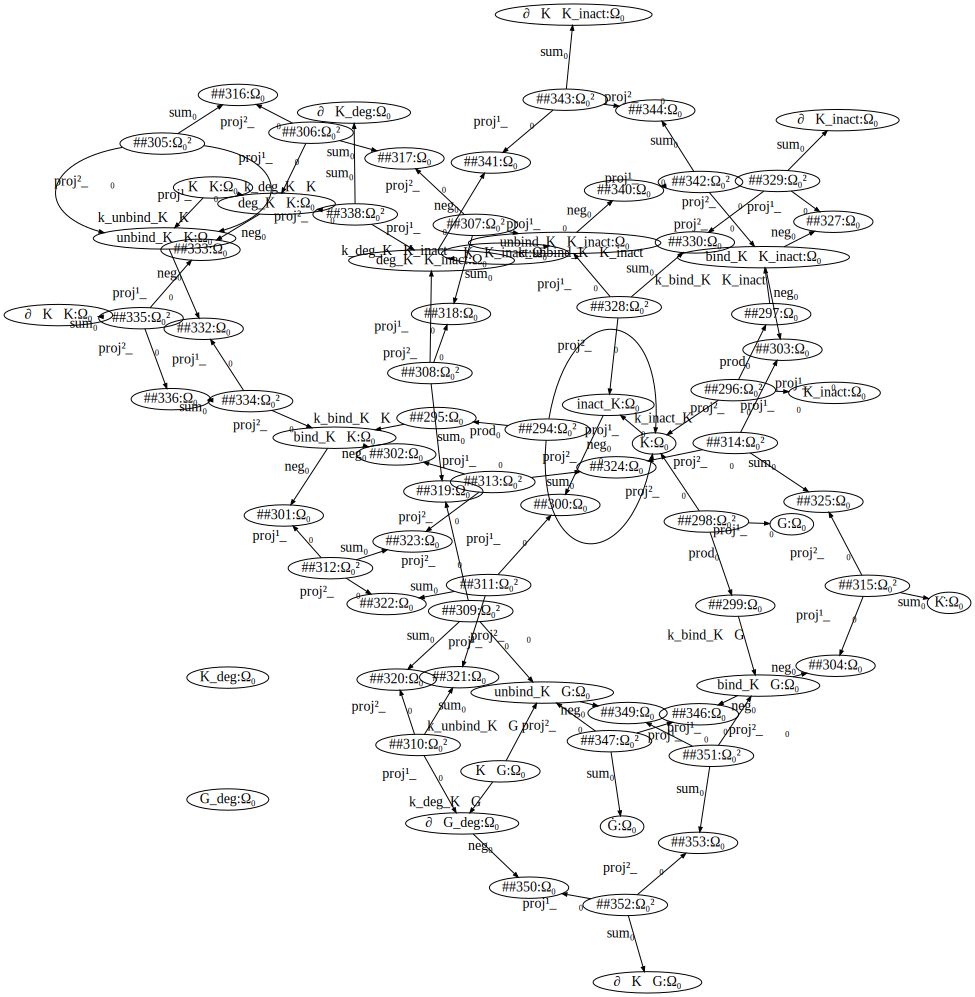

In [7]:
@present DiffusionSpace2D(FreeExtCalc2D) begin
  X::Space
  k::Hom(Form1(X), Form1(X)) # diffusivity of space, usually constant (scalar multiplication)
  proj¹_⁰⁰₀::Hom(Form0(X) ⊗ Form0(X), Form0(X))
  proj²_⁰⁰₀::Hom(Form0(X) ⊗ Form0(X), Form0(X))
  sum₀::Hom(Form0(X) ⊗ Form0(X), Form0(X))
  prod₀::Hom(Form0(X) ⊗ Form0(X), Form0(X))
end

SIRD = LabelledReactionNet{Float64, Float64}([:S=>0.0, :I=>0.0, :R=>0.0, :D=>0.0],
                                             (:inf=>0.01)=>((:S,:I)=>(:I,:I)),
                                             (:rec=>0.001)=>(:I=>:R),
                                             (:death=>0.01)=>(:I=>:D))

expand_pres!(DiffusionSpace2D, lrn)

Diffusion = @free_diagram DiffusionSpace2D begin
  (C, Ċ)::Form0{X}
  Ċ == ⋆₀⁻¹{X}(dual_d₁{X}(⋆₁{X}(k(d₀{X}(C)))))
end

Superposition = @free_diagram DiffusionSpace2D begin
  (Ċ₁, Ċ₂, Ċ, C)::Form0{X}
  Ċ₁₂::otimes{Form0{X}, Form0{X}}

  Ċ₁ == proj¹_⁰⁰₀(Ċ₁₂)
  Ċ₂ == proj²_⁰⁰₀(Ċ₁₂)
  Ċ == sum₀(Ċ₁₂)
  Ċ == ∂ₜ{Form0{X}}(C)
end;


cath_dec = pn2dec(DiffusionSpace2D, lrn)
to_graphviz(cath_dec,
node_labels=true, prog="neato",
node_attrs=Dict(:shape=>"oval"),
graph_attrs=Dict(:nodesep=>"4.0"))

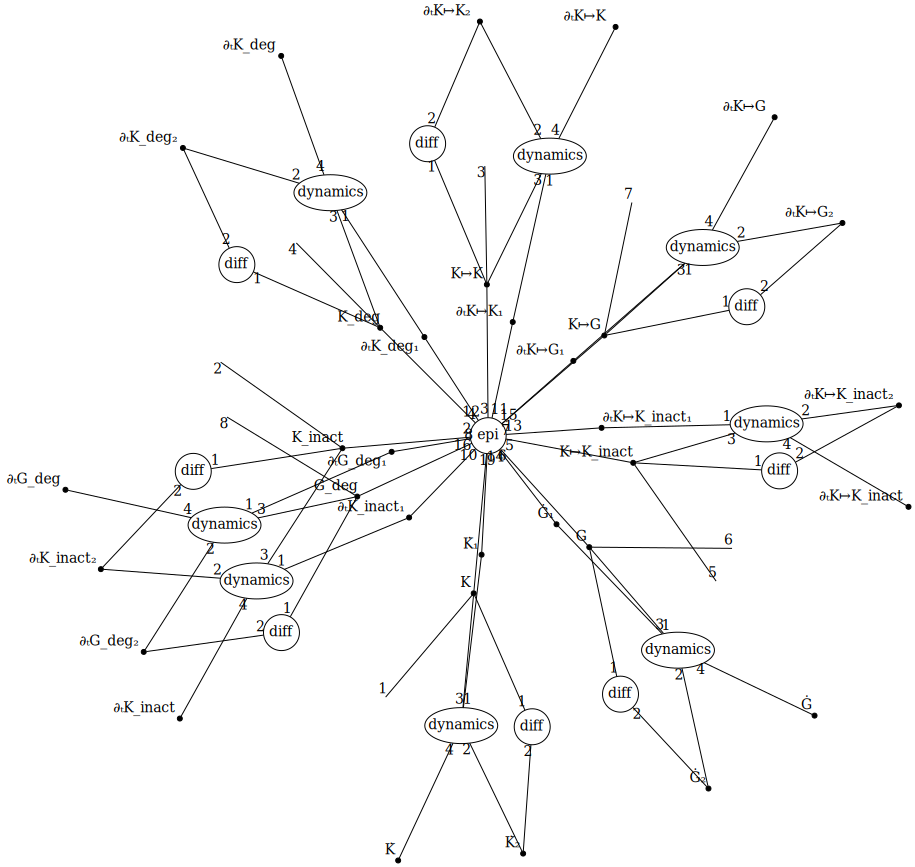

In [34]:
compose_epi = @relation (S,I,R) begin
  epi(S,I,R, D, Ṡ₁,İ₁, Ṙ₁, Ḋ₁)
  diff(S, Ṡ₂)
  diff(I, İ₂)
  diff(R, Ṙ₂)
  diff(D, Ḋ₂)
  dynamics(Ṡ₁,Ṡ₂, S, Ṡ)
  dynamics(İ₁,İ₂, I, İ)
  dynamics(Ṙ₁,Ṙ₂, R, Ṙ)
  dynamics(Ḋ₁,Ḋ₂, D, Ḋ)
end

using Unicode
using Catlab.WiringDiagrams
get_dt(s::Symbol) = length(string(s)) > 1 ? Symbol(:∂ₜ, s) : Symbol(Unicode.normalize("$s"*"̇"))
compose_pn(pn) = begin
    rel = RelationDiagram(0)
    juncts = map(snames(pn)) do s
        dt = get_dt(s)
        names = [s, Symbol(dt, "₁"), Symbol(dt, "₂"), dt]
        jn = add_junctions!(rel, 4, variable = names)
        boxes = add_parts!(rel, :Box, 2, name=[:dynamics, :diff])
        add_parts!(rel, :Port, 4, junction=jn[[2,3,1,4]], box=boxes[1])
        add_parts!(rel, :Port, 2, junction=jn[[1,3]], box=boxes[2])
        jn[1:2]
    end
    e_box = add_part!(rel, :Box, name=:epi)
    add_parts!(rel, :Port, length(juncts) * 2, junction=vcat(first.(juncts), last.(juncts)), box=e_box)
    add_parts!(rel, :OuterPort, ns(pn), outer_junction = first.(juncts))
    rel
end

to_graphviz(compose_pn(lrn), box_labels=:name, junction_labels=:variable,
graph_attrs=Dict(:start => "1", :overlap=>"scale"), port_labels=true)

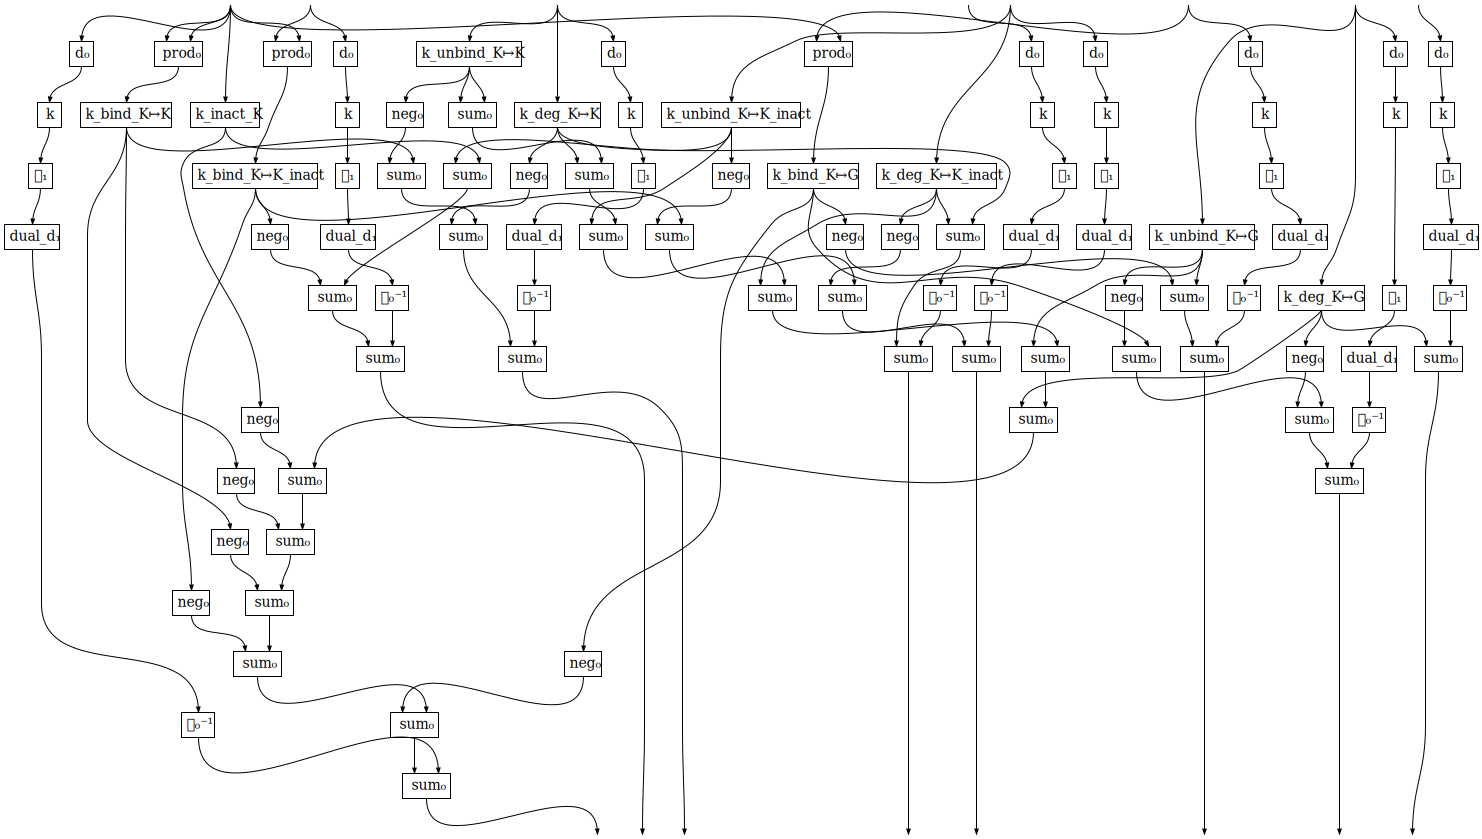

In [9]:
composed_epi = oapply(compose_pn(lrn), vcat(
    vcat([[OpenDiagram(Superposition, [:Ċ₁, :Ċ₂, :C, :Ċ]), OpenDiagram(Diffusion, [:C, :Ċ])] for i in 1:ns(lrn)]...),
    [OpenDiagram(cath_dec, vcat(snames(lrn), get_dt.(snames(lrn))))]
));

res = diag2dwd(composed_epi.functor, arg_order = snames(lrn))

new_res = deepcopy(res)
new_res.diagram[:outer_out_port_type] .= nothing
new_res.diagram[:outer_in_port_type] .= nothing
new_res.diagram[:out_port_type] .= nothing
new_res.diagram[:in_port_type] .= nothing
to_graphviz(new_res)
#=to_graphviz(composed_epi.functor,
node_labels=true, prog="neato",
node_attrs=Dict(:shape=>"oval"),
graph_attrs=Dict(:nodesep=>"0.5"))=#


In [10]:
s = EmbeddedDeltaSet2D("../../../../meshes/pipe_fine.stl")
sd = dual(s);

In [11]:
funcs = sym2func(sd)

merge!(funcs, gen_functions(lrn, s))

funcs[:k] = Dict(:operator => 1.0 * I(ne(sd)), :type => MatrixFunc())

Dict{Symbol, Any} with 2 entries:
  :type     => MatrixFunc()
  :operator => [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.…

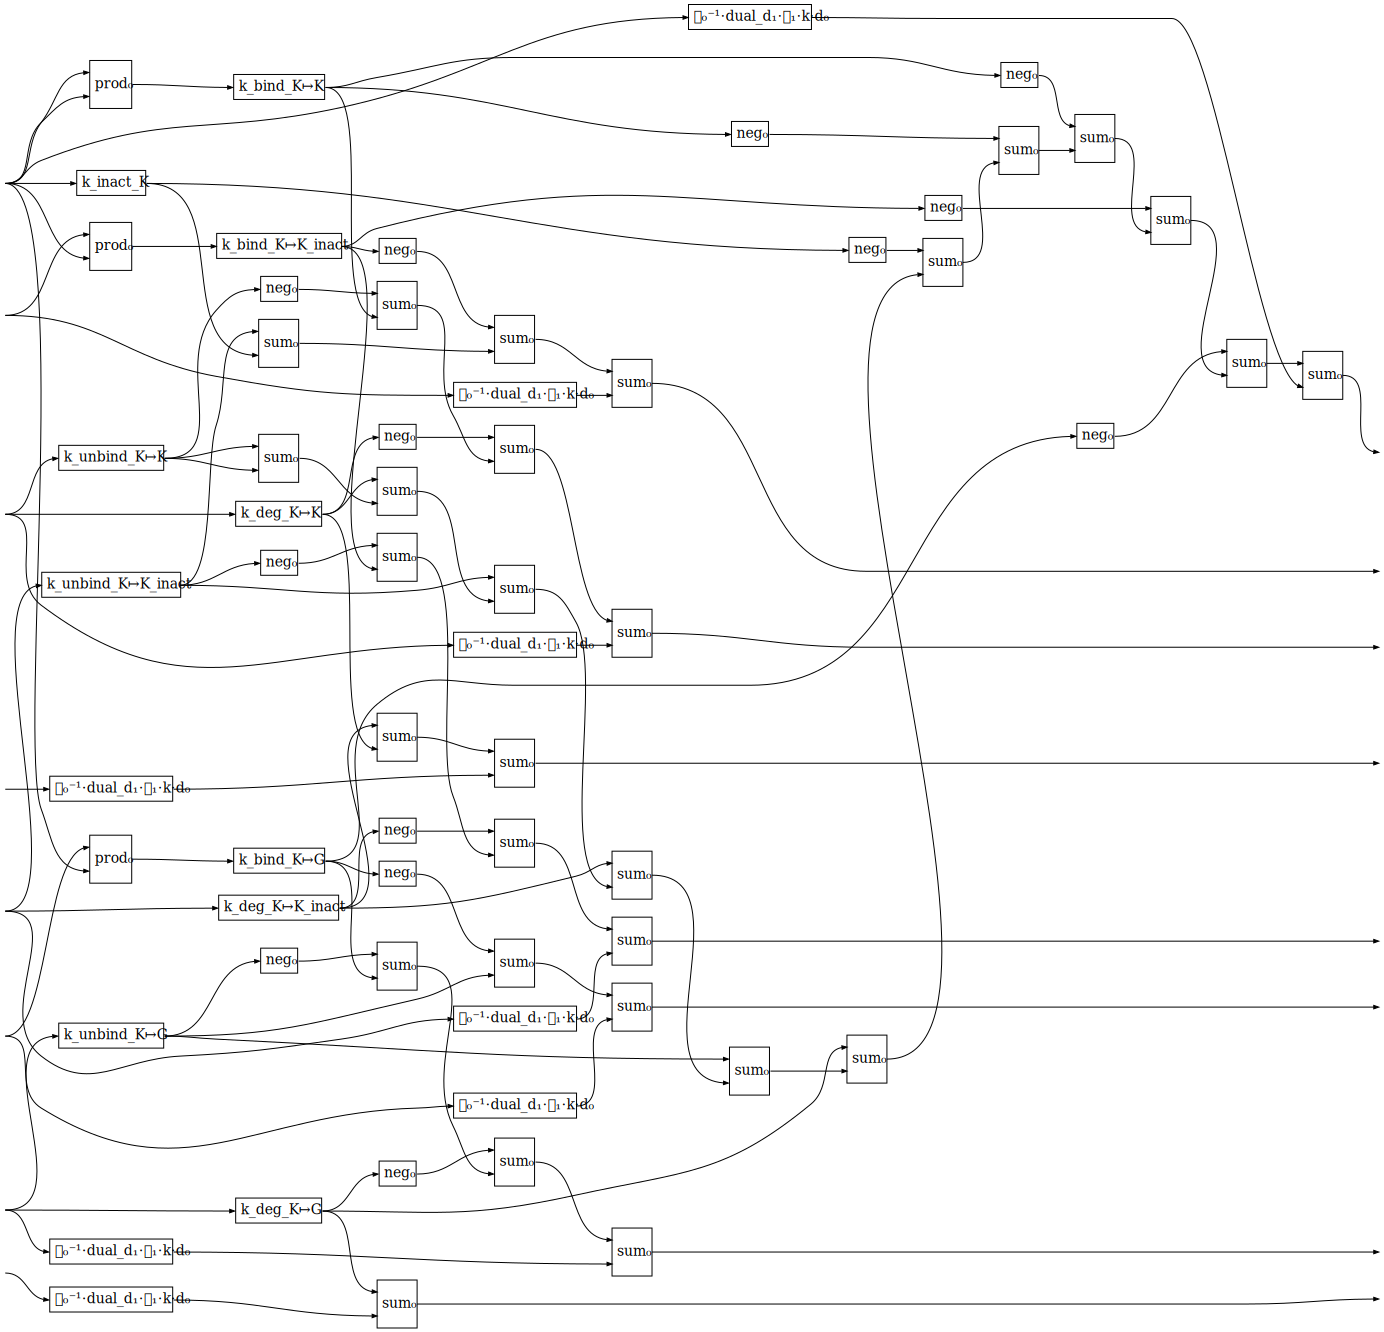

In [12]:
cont_dwd = deepcopy(res)
Examples.contract_matrices!(cont_dwd, funcs)
new_res = deepcopy(cont_dwd)
new_res.diagram[:outer_out_port_type] .= nothing
new_res.diagram[:outer_in_port_type] .= nothing
new_res.diagram[:out_port_type] .= nothing
new_res.diagram[:in_port_type] .= nothing
to_graphviz(new_res, orientation=LeftToRight)

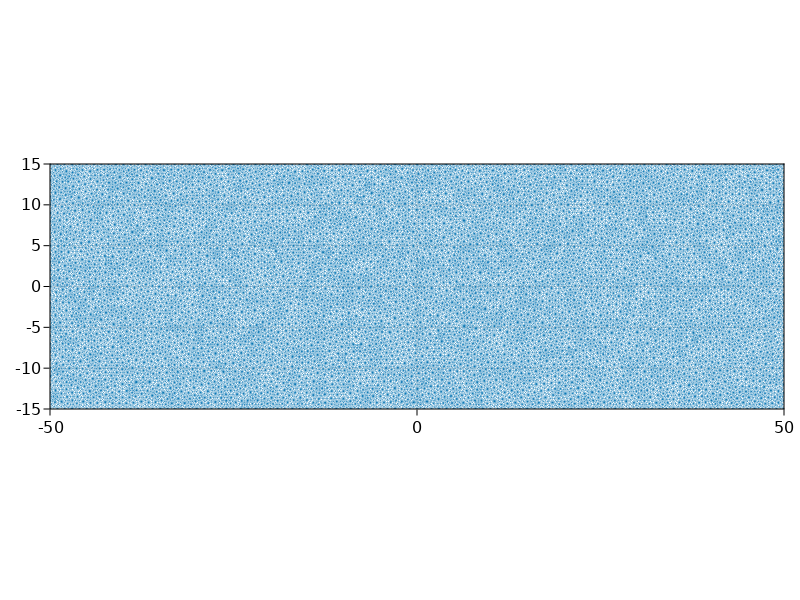

In [43]:
fig, ax, ob = wireframe(sd, linewidth=0.2)
ax.aspect = AxisAspect(3.0)
xlims!(ax, (-50,50))
ylims!(ax, (-15,15))
save("test.svg", fig)
fig

In [14]:
x1 = -30.0
x2 = -20.0
state_dict = Dict([name => zeros(nv(s)) for name in snames(lrn)])
state_dict[:G] = ones(nv(s)) * 714000
state_dict[:Spike] = ones(nv(s)) * 66000

c_dist = MvNormal([(x1+x2)/2, 0.0], [4.0, 4.0])
c_gauss = [pdf(c_dist, [p[1], p[2]]) for p in s[:point]]
max_gauss = maximum(c_gauss)
c_gauss ./= max_gauss
state_dict[:K] = c_gauss * 33000
state_dict[:S] = c_gauss * 33000
u0 =  vcat([state_dict[s] for s in snames(lrn)]...);

In [15]:
rd = res.diagram[4, :outer_out_port_type]
rd2 = res.diagram[5, :outer_out_port_type]
rd2[:type] = rd[:type]
res.diagram[5, :outer_out_port_type] = rd2

Dict{Symbol, Any} with 2 entries:
  :type => Form0(X)
  :name => Symbol("∂ₜK↦K_inact")

In [16]:
diffusion_func, code = gen_sim(cont_dwd, funcs, sd);

prob = ODEProblem(diffusion_func, u0, (0.0, 100.0))
sol = solve(prob, Tsit5(), progress=true, progress_steps = 100);

ODE   0%|                                               |  ETA: N/A
ODE  12%|█████▉                                         |  ETA: 0:00:23
ODE  28%|█████████████▏                                 |  ETA: 0:00:15
ODE  43%|████████████████████▏                          |  ETA: 0:00:10
ODE  57%|███████████████████████████                    |  ETA: 0:00:07
ODE  72%|█████████████████████████████████▊             |  ETA: 0:00:04
ODE  86%|████████████████████████████████████████▋      |  ETA: 0:00:02
ODE 100%|███████████████████████████████████████████████| Time: 0:00:15


In [17]:
snames(lrn)

8-element Vector{Symbol}:
 :K
 :K_inact
 Symbol("K↦K")
 :K_deg
 Symbol("K↦K_inact")
 :G
 Symbol("K↦G")
 :G_deg

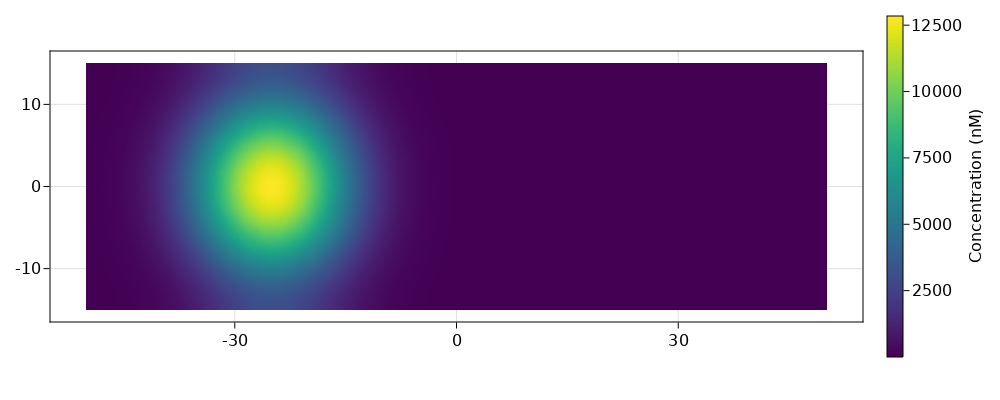

In [78]:
fig = Figure(resolution = (1000, 400))
ax, ob = mesh(fig[1,1], s, color=sol(10.0)[(1:nv(s)) .+ 7 * nv(s)])
Colorbar(fig[1,2], ob, label="Concentration (nM)")
ax.aspect = AxisAspect(3.0)
fig

In [19]:
s[1, :point]

3-element Point{3, Float32} with indices SOneTo(3):
 -24.96289
   1.390456
   0.0

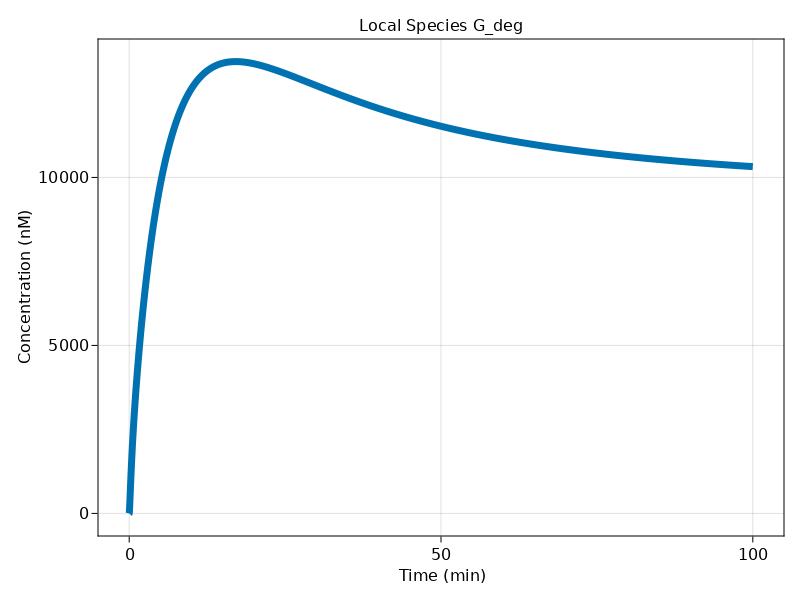

In [59]:
#↦
species = Symbol("G_deg")
index = findfirst(v -> v == species, snames(lrn)) - 1
lines(sol.t, [sol(t)[1 + index*nv(s)] for t in sol.t], linewidth=7, axis = (; title="Local Species " * String(sname(lrn, index+1)),
                                                                              ylabel="Concentration (nM)",
                                                                              xlabel="Time (min)"))

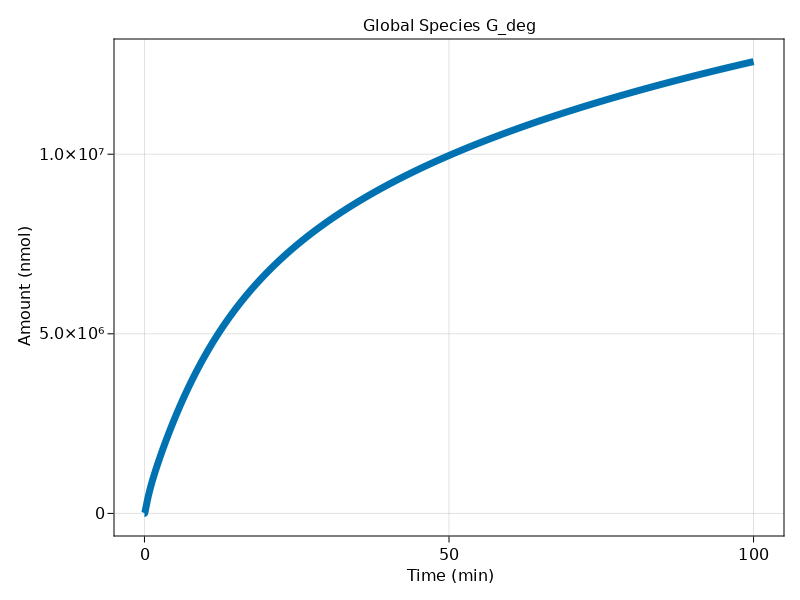

In [79]:
hs = hodge_star(Val{0}, sd)
lines(sol.t, [sum(hs * sol(t)[(1:nv(s)) .+ index * nv(s)]) for t in sol.t],linewidth=7,  axis = (; title="Global Species " * String(sname(lrn, index+1)),
                                                                              ylabel="Amount (nmol)",
                                                                              xlabel="Time (min)"))